In [5]:
import numpy as np
import math
import os
import traceback
from scipy import signal
from scipy import optimize
# import UDIP_4_Lib_V2 as UDIP_Lib_3  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *

# Ground Software Testing

In [52]:
year = 2024
sourceName = 'UDIP115.dat'
#packets = import_data(f'../{year}/{year}_packet.json')
packets = import_data(f'{year}_packet_FMS_1.json')

In [53]:
print(sourceName)
print()
SensNum = len(packets['packets']['Sensor'])
print(f'There are {SensNum} Sensor packets')
print()
LinSweepNum = len(packets['packets']['Full'])
print(f'There are {LinSweepNum} Linear Sweeps')
print()
DensSweepNum = len(packets['packets']['Dense'])
print(f'There are {DensSweepNum} Dense Sweeps')

UDIP115.dat

There are 48077 Sensor packets

There are 902 Linear Sweeps

There are 101 Dense Sweeps


## Fitting Functions

In [13]:
def data_processing(V, I):
    #Imax = np.argmax(I) #find index of maximum Current
    Imax = max(I)  # Find the maximum current value
    #print(f'Imax = {Imax}')
    #Imin = np.argmin(I) #find index of minimum Current
    Imin = min(I)  # Find the minimum current value
    #print(f'Imin = {Imin}')

    V_proc = []
    I_proc = []
    for i in range(0,len(V)):
        #if ((V[i] > -0.8) & (V[i] < 0.5)):
        if((I[i] > (Imin + 9e-10)) & (I[i] < (Imax - 9e-10))):
            V_proc.append(V[i])
            I_proc.append(I[i])
    
    return V_proc, I_proc

In [14]:
def slope_fit(V_arr, I_arr, adcNum):
    
    V_proc, I_proc = V_arr, I_arr
    
    if(adcNum == 0):
        guess = [-1e-7, 6.3e-7]    #intial guess (m, b)
        #b = ((-np.inf, -24937.5e-9),(np.inf, 22062.5e-9)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
    elif(adcNum == 1):
        guess = [-1e-7, 6.5e-7]    #intial guess (m, b)
        #b = ((-np.inf, -1234.1e-9),(np.inf, 1050.6e-9)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
    elif(adcNum == 2):
        guess = [-1e-7, 5.8e-8]    #intial guess (m, b)
        #b = ((-np.inf, -50.03e-9),(np.inf, 58.8e-9)) #bounds
        #b = ((-np.inf, -58.8e-9),(np.inf, 50.03e-9)) #bounds
        #b = ((-np.inf, -5.8e-8),(np.inf, 5.8e-8)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
        V_proc, I_proc = data_processing(V_arr, I_arr)

    popt, pcov = optimize.curve_fit(model, V_proc, I_proc, guess, bounds = b)
    
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov


def model(V, m1, b):
    return lin_fit(V, m1, b)


def lin_fit(x, m, y_int): # linear fit
    return m * x + y_int

adc0_min = -24937.5e-9  # Amps
adc0_max = 22062.5e-9

acd1_min = -1234.1e-9
adc1_max = 1050.6e-9

adc2_min = -58.8e-9
adc2_max = 50.03e-9


## Sensor Packets

In [54]:
sensorNum = 10
Sensor = packets['packets']['Sensor'][f'{sensorNum}']

print(Sensor)

{'Start': 2656, 'Stop': 2663, 'Count': 10, 'Acceleration': [-0.2619721261657759, -0.04191554018652415, 9.567222047574138, [65535]], 'Spin Rate': [0.002136181575433912, 0.3012016021361816, 0.5778371161548732], 'Magnetic Field': [-15.87158203125, -5.9619140625, -59.23583984375], 'Temperature': [17.934065934065938], 'Photo Diode': [0.8287271062271062]}


In [26]:
sensor = packets['packets']['Sensor']
print(len(sensor))
for i in range(0, len(sensor)):
    accel = sensor[f'{i}']['Acceleration']
    print(f'acceleration {i}: {accel}')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



acceleration 35203: [-0.34580320653882424, -0.17814104579272763, 9.839673058786545, [65535]]
acceleration 35204: [-0.2514932411191449, -0.10478885046631038, 9.78727863355339, [65535]]
acceleration 35205: [-0.272451011212407, -0.07335219532641726, 9.818715288693282, [65535]]
acceleration 35206: [-0.29340878130566905, -0.1362255056062035, 9.724405323273603, [65535]]
acceleration 35207: [-0.272451011212407, -0.15718327569946555, 9.661532012993817, [65535]]
acceleration 35208: [-0.3143665513989311, -0.1362255056062035, 9.776799748506757, [65535]]
acceleration 35209: [-0.3248454364455622, -0.0838310803730483, 9.703447553180341, [65535]]
acceleration 35210: [-0.40867651681861045, -0.20957770093262076, 9.640574242900554, [65535]]
acceleration 35211: [-0.35628209158545526, -0.09430996541967934, 9.525306507387613, [65535]]
acceleration 35212: [-0.24101435607251387, -0.15718327569946555, 9.619616472807293, [65535]]
acceleration 35213: [-0.2619721261657759, -0.15718327569946555, 9.703447553180341

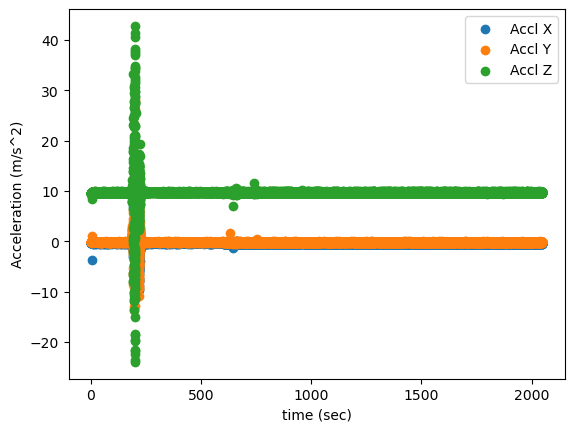

In [55]:
sensor = packets['packets']['Sensor']

accX = []
accY = []
accZ = []

accRawX = []
accRawY = []
accRawZ = []


time = []

for i in range (0, len(sensor)):
    accX.append(sensor[f'{i}']['Acceleration'][0])
    accRawX.append(sensor[f'{i}']['Acceleration'][0] * 95.43)
    
    accY.append(sensor[f'{i}']['Acceleration'][1])
    accRawY.append(sensor[f'{i}']['Acceleration'][1] * 95.43)
    
    accZ.append(sensor[f'{i}']['Acceleration'][2])
    accRawZ.append(sensor[f'{i}']['Acceleration'][2] * 95.43)
    
    time.append(sensor[f'{i}']['Start'] / 1000)
    
num = np.linspace(1,len(sensor),len(sensor))

plt.scatter(time, accX, label = 'Accl X')
plt.scatter(time, accY, label = 'Accl Y')
plt.scatter(time, accZ, label = 'Accl Z')
plt.ylabel('Acceleration (m/s^2)')
plt.xlabel('time (sec)')
plt.legend()
plt.show()

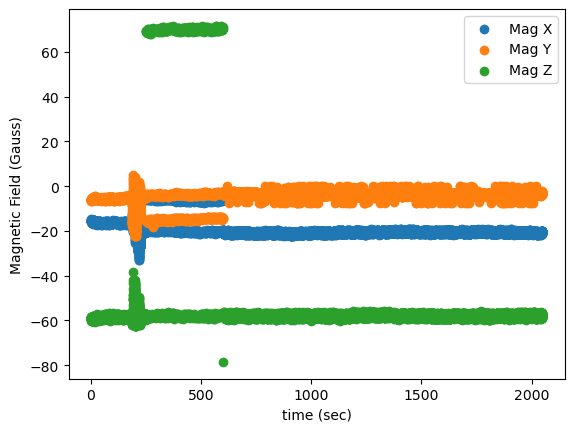

In [45]:
sensor = packets['packets']['Sensor']

magX = []
magY = []
magZ = []

magRawX = []
magRawY = []
magRawZ = []

time = []

for i in range (0, len(sensor)):
    magX.append(sensor[f'{i}']['Magnetic Field'][0])
    magRawX.append(sensor[f'{i}']['Magnetic Field'][0] * 409.6)
    
    magY.append(sensor[f'{i}']['Magnetic Field'][1])
    magRawY.append(sensor[f'{i}']['Magnetic Field'][1] * 409.6)
    
    magZ.append(sensor[f'{i}']['Magnetic Field'][2])
    magRawZ.append(sensor[f'{i}']['Magnetic Field'][2] * 409.6)
    
    
    time.append(sensor[f'{i}']['Start'] / 1000)
    
num = np.linspace(1,len(sensor),len(sensor))

plt.scatter(time, magX, label = 'Mag X')
plt.scatter(time, magY, label = 'Mag Y')
plt.scatter(time, magZ, label = 'Mag Z')
plt.ylabel('Magnetic Field (Gauss)')
plt.xlabel('time (sec)')
plt.legend()
plt.show()

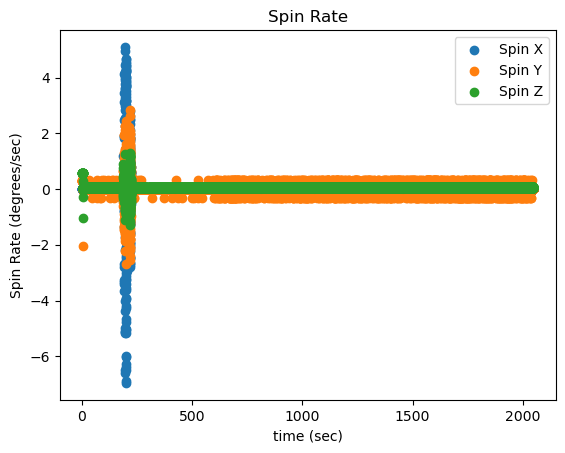

In [46]:
sensor = packets['packets']['Sensor']

spinX = []
spinY = []
spinZ = []

spinXRaw = []
spinYRaw = []
spinZRaw = []

time = []

for i in range (0, len(sensor)):
    spinX.append(sensor[f'{i}']['Spin Rate'][0])
    spinXRaw.append(sensor[f'{i}']['Spin Rate'][0] * 936.25)
    
    spinY.append(sensor[f'{i}']['Spin Rate'][1])
    spinYRaw.append(sensor[f'{i}']['Spin Rate'][1] * 936.25)
    
    spinZ.append(sensor[f'{i}']['Spin Rate'][2])
    spinZRaw.append(sensor[f'{i}']['Spin Rate'][2] * 936.25)
    
    time.append(sensor[f'{i}']['Start'] / 1000)
    
num = np.linspace(1,len(sensor),len(sensor))

plt.scatter(time, spinX, label = 'Spin X')
plt.scatter(time, spinY, label = 'Spin Y')
plt.scatter(time, spinZ, label = 'Spin Z')
plt.title('Spin Rate')
plt.ylabel('Spin Rate (degrees/sec)')
plt.xlabel('time (sec)')
plt.legend()
plt.show()

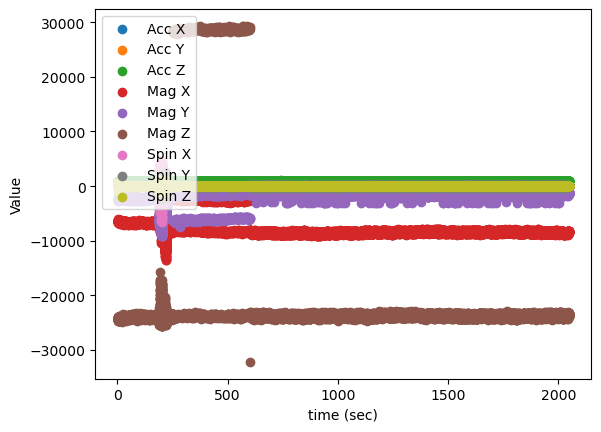

In [49]:
plt.scatter(time, accRawX, label = "Acc X")
plt.scatter(time, accRawY, label = "Acc Y")
plt.scatter(time, accRawZ, label = "Acc Z")

plt.scatter(time, magRawX, label = "Mag X")
plt.scatter(time, magRawY, label = "Mag Y")
plt.scatter(time, magRawZ, label = "Mag Z")

plt.scatter(time, spinXRaw, label = "Spin X")
plt.scatter(time, spinYRaw, label = "Spin Y")
plt.scatter(time, spinZRaw, label = "Spin Z")

plt.ylabel('Value')
plt.xlabel('time (sec)')
plt.legend()
plt.show()

In [56]:
sensor = packets['packets']['Sensor']

temps = []

for i in range (0, len(sensor)):
    temps.append(sensor[f'{i}']['Temperature'])
    

print(temps)


[[18.417582417582423], [17.853479853479847], [17.531135531135533], [17.69230769230769], [17.531135531135533], [17.69230769230769], [17.853479853479847], [16.402930402930405], [16.725274725274723], [16.88644688644689], [17.934065934065938], [16.402930402930405], [17.934065934065938], [17.208791208791204], [17.77289377289377], [17.047619047619047], [16.402930402930405], [17.369963369963376], [17.128205128205128], [17.289377289377285], [17.853479853479847], [17.531135531135533], [17.69230769230769], [17.531135531135533], [16.161172161172157], [17.934065934065938], [16.402930402930405], [17.77289377289377], [15.838827838827843], [18.336996336996332], [17.369963369963376], [17.047619047619047], [17.77289377289377], [17.450549450549453], [17.77289377289377], [17.047619047619047], [16.80586080586081], [16.80586080586081], [17.934065934065938], [17.853479853479847], [15.919413919413921], [17.531135531135533], [17.77289377289377], [16.483516483516485], [16.88644688644689], [15.838827838827843],

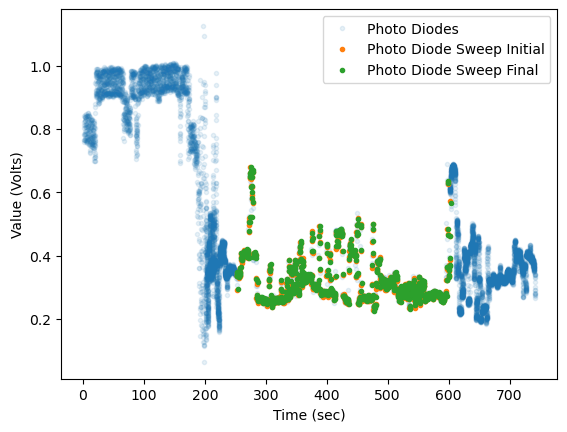

In [77]:
sensor = packets['packets']['Sensor']

sweep = packets['packets']['Full']

phDiodes = []
times = []

phDiodesInitial = []
timeInitial = []

phDiodesFinal = []
timeFinal = []

for i in range (0, len(sensor)):
    
    phDiodes.append(sensor[f'{i}']['Photo Diode'])
    times.append(sensor[f'{i}']['Start'] / 1000)
    

for i in range (0, len(sweep)):
    
    phDiodesInitial.append(sweep[f'{i}']['PhotoDiodeInitial'])
    timeInitial.append(sweep[f'{i}']['Start'] / 1000)
    
    phDiodesFinal.append(sweep[f'{i}']['PhotoDiodeFinal'])
    timeFinal.append(sweep[f'{i}']['Stop'] / 1000)

#print(phDiodes)

plt.plot(times[0:10000], phDiodes[0:10000], '.', label = 'Photo Diodes', alpha = 0.1) 
plt.plot(timeInitial, phDiodesInitial, '.', label = 'Photo Diode Sweep Initial')
plt.plot(timeFinal, phDiodesFinal, '.', label = 'Photo Diode Sweep Final')
plt.xlabel('Time (sec)')
plt.ylabel('Value (Volts)')
plt.legend()
plt.show()


## Voltage Sweeps

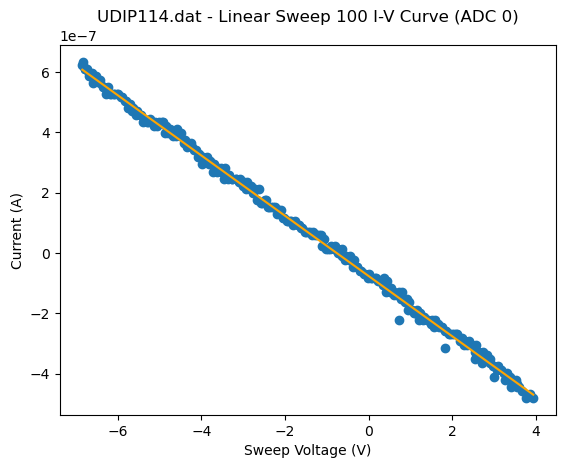

ADC_0 Slope = -1.0004e-07
ADC_0 Standard Error = 3.1230e-10


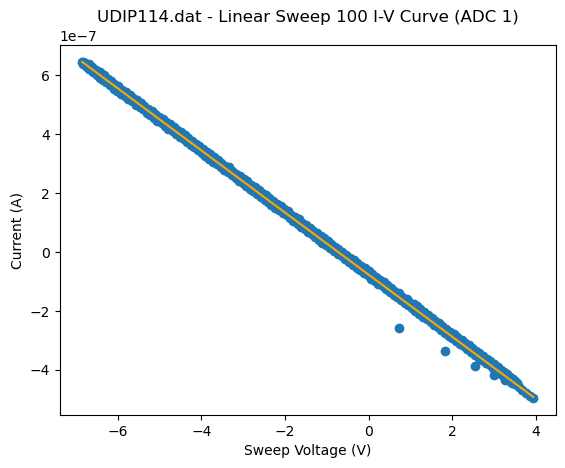

ADC_1 Slope = -1.0552e-07
ADC_1 Standard Error = 3.1484e-10


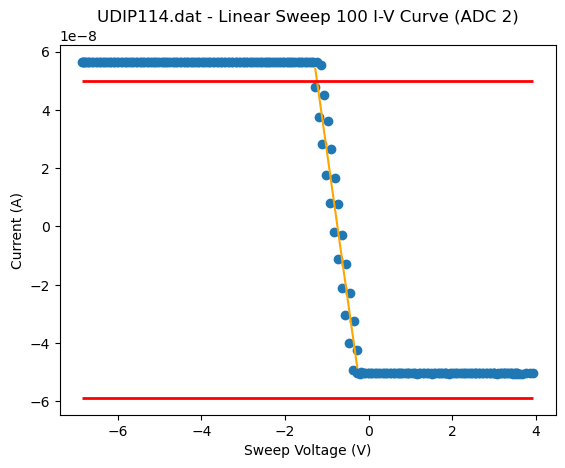

ADC_2 Slope = -1.0220e-07
ADC_2 Standard Error = 7.9438e-09


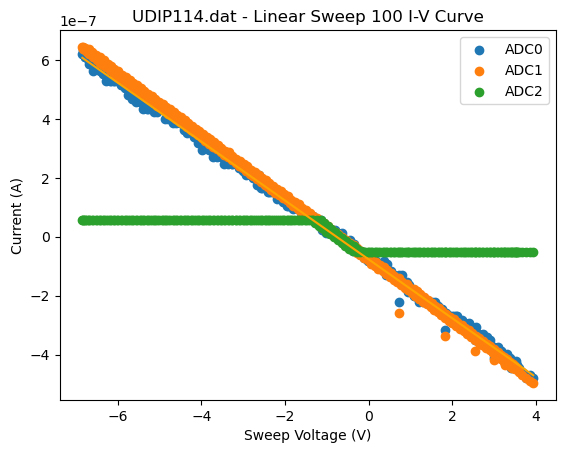

ADC_0 Slope = -1.0004e-07
ADC_1 Slope = -1.0552e-07
ADC_2 Slope = -1.0220e-07

ADC_0 Standard Error = 3.1230e-10
ADC_1 Standard Error = 3.1484e-10
ADC_2 Standard Error = 7.9438e-09


In [15]:
sweepNum = 100
V = packets['packets']['Full'][f'{sweepNum}']['Voltage']
I0 = packets['packets']['Full'][f'{sweepNum}']['Current0']
I1 = packets['packets']['Full'][f'{sweepNum}']['Current1']
I2 = packets['packets']['Full'][f'{sweepNum}']['Current2']

# num = np.linspace(1,len(I2),len(I2))
# plt.scatter(num,I2)
# plt.title(f'{sourceName} - Linear Sweep {sweepNum} - ADC 2 Values in order')
# plt.show()

# num = np.linspace(1,len(V),len(V))
# plt.scatter(num,V)
# plt.title(f'{sourceName} - Linear Sweep {sweepNum} - Voltage Values in order')
# plt.show()

plt.scatter(V[1:],I0[1:])
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 0)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_0 = "{:.4e}".format(popt[0])
std_err_0 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_0 Standard Error = {std_err_0}')

plt.scatter(V[1:],I1[1:])
x, y, popt, pcov = slope_fit(V, I1, 1) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 1)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_1 = "{:.4e}".format(popt[0])
std_err_1 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_1 Standard Error = {std_err_1}')

plt.scatter(V[1:],I2[1:])
x, y, popt, pcov = slope_fit(V, I2, 2) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.hlines(y=adc2_max, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.hlines(y=adc2_min, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 2)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_2 = "{:.4e}".format(popt[0])
std_err_2 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_2 Slope = {slope_2}')
print(f'ADC_2 Standard Error = {std_err_2}')


plt.scatter(V[1:],I0[1:], label = "ADC0")
plt.scatter(V[1:],I1[1:], label = "ADC1")
plt.scatter(V[1:],I2[1:], label = "ADC2")
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_2 Slope = {slope_2}')
print()
print(f'ADC_0 Standard Error = {std_err_0}')
print(f'ADC_1 Standard Error = {std_err_1}')
print(f'ADC_2 Standard Error = {std_err_2}')

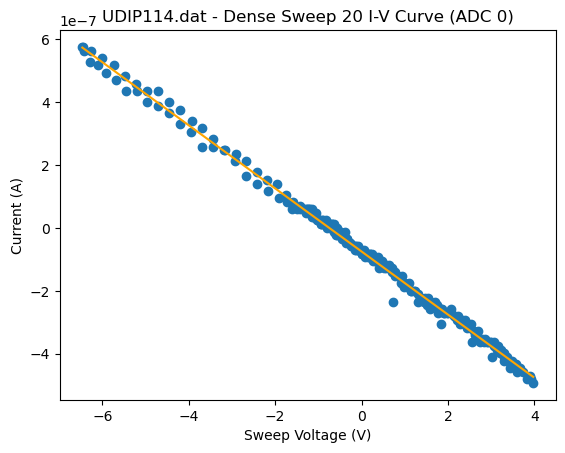

ADC_0 Slope = -1.0027e-07
ADC_0 Standard Error = 4.2422e-10


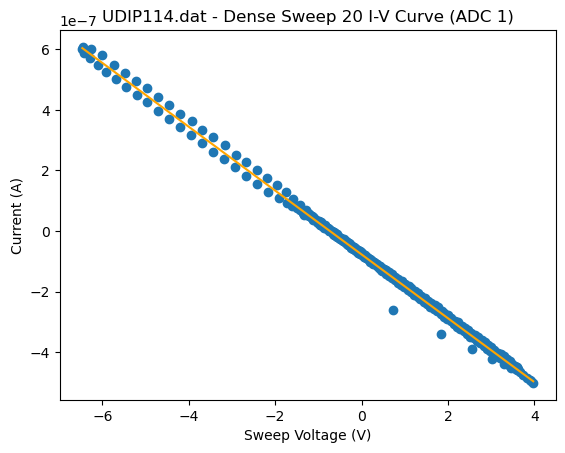

ADC_1 Slope = -1.0534e-07
ADC_1 Standard Error = 4.3817e-10


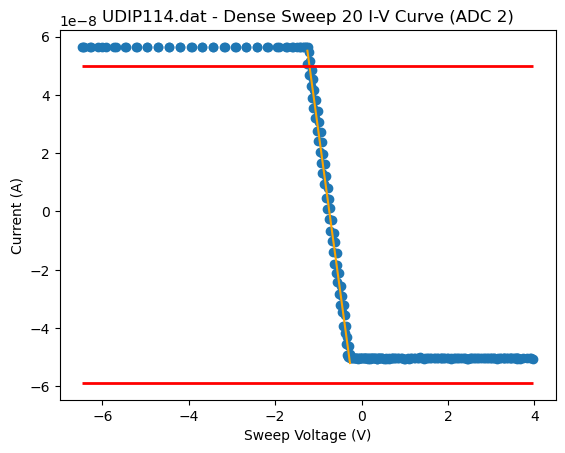

ADC_2 Slope = -1.0873e-07
ADC_2 Standard Error = 1.9358e-09


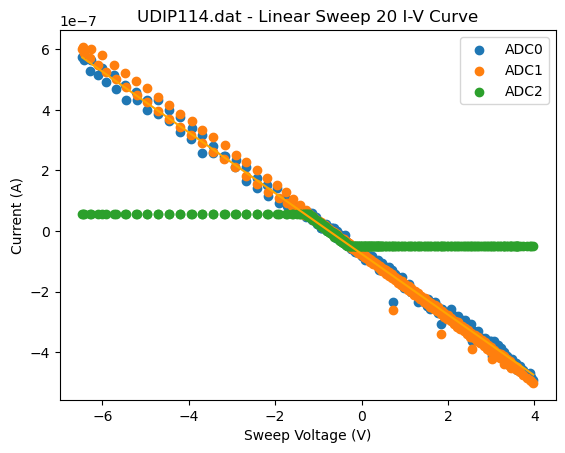

ADC_0 Slope = -1.0027e-07
ADC_1 Slope = -1.0534e-07
ADC_2 Slope = -1.0873e-07

ADC_0 Standard Error = 4.2422e-10
ADC_1 Standard Error = 4.3817e-10
ADC_2 Standard Error = 1.9358e-09


In [16]:
sweepNum = 20
V = packets['packets']['Dense'][f'{sweepNum}']['Voltage']
I0 = packets['packets']['Dense'][f'{sweepNum}']['Current0']
I1 = packets['packets']['Dense'][f'{sweepNum}']['Current1']
I2 = packets['packets']['Dense'][f'{sweepNum}']['Current2']

# num = np.linspace(1,len(I0),len(I0))
# plt.scatter(num,I0)
# plt.title(f'{sourceName} - Dense Sweep {sweepNum} - ADC 0 Values in order')
# plt.show()

plt.scatter(V[1:],I0[1:])
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 0)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_0 = "{:.4e}".format(popt[0])
std_err_0 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_0 Standard Error = {std_err_0}')

plt.scatter(V[1:],I1[1:])
x, y, popt, pcov = slope_fit(V, I1, 1) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 1)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_1 = "{:.4e}".format(popt[0])
std_err_1 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_1 Standard Error = {std_err_1}')

plt.scatter(V[1:],I2[1:])
x, y, popt, pcov = slope_fit(V, I2, 2) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.hlines(y=adc2_max, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.hlines(y=adc2_min, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 2)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_2 = "{:.4e}".format(popt[0])
std_err_2 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_2 Slope = {slope_2}')
print(f'ADC_2 Standard Error = {std_err_2}')


plt.scatter(V[1:],I0[1:], label = "ADC0")
plt.scatter(V[1:],I1[1:], label = "ADC1")
plt.scatter(V[1:],I2[1:], label = "ADC2")
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_2 Slope = {slope_2}')
print()
print(f'ADC_0 Standard Error = {std_err_0}')
print(f'ADC_1 Standard Error = {std_err_1}')
print(f'ADC_2 Standard Error = {std_err_2}')


## Time Steps


The average time step in UDIP114.dat is 384.5927552140505


Text(0, 0.5, 'Difference from Prev Packet (ms)')

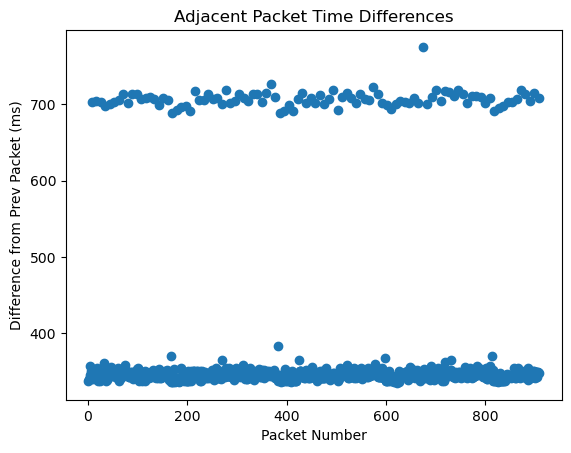

In [22]:
sweepNum = 10
tAvg = 0
packetsLen = len(packets['packets']['Full'])
tDiffArr = []
for i in range(1, packetsLen):
#for i in range(1, 165):
    tInitial = packets['packets']['Full'][f'{i}']['Start']
    tFinal = packets['packets']['Full'][f'{i}']['Stop']
    #print(f'Packet {i} tInitial - {tInitial}')
    if(i > 1):
        tInitialPrev = packets['packets']['Full'][f'{i-1}']['Start']
        tFinalPrev = packets['packets']['Full'][f'{i-1}']['Stop']
        tFinalDiff = tFinal - tFinalPrev
        tInitialDiff = tInitial - tInitialPrev
        tAvg = tAvg + tInitialDiff
        tDiffArr.append(tFinalDiff)

tAvg = tAvg/packetsLen
#tAvg = tAvg/164
print()
print(f'The average time step in {sourceName} is {tAvg}')

num = np.linspace(1,len(tDiffArr),len(tDiffArr))
plt.scatter(num, tDiffArr)
plt.title('Adjacent Packet Time Differences')
plt.xlabel('Packet Number')
plt.ylabel('Difference from Prev Packet (ms)')

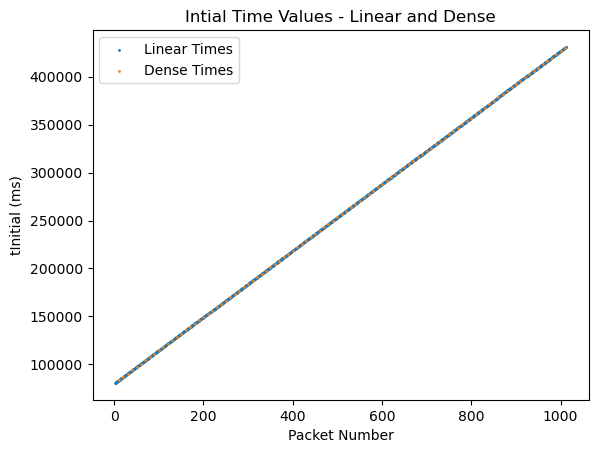

In [20]:
sweepNum = 10
packetsLen = len(packets['packets']['Full'])

tInitialArr_Lin = []
tCountArr_Lin = []

tInitialArr_Dens = []
tCountArr_Dens = []

for i in range(1, packetsLen):
    
    tInitial_Lin = packets['packets']['Full'][f'{i}']['Start']
    count_Lin = packets['packets']['Full'][f'{i}']['Count']
    
    tInitialArr_Lin.append(tInitial_Lin)
    tCountArr_Lin.append(count_Lin)
    
    if(i < len(packets['packets']['Dense'])):
        tInitial_Dens = packets['packets']['Dense'][f'{i}']['Start']
        count_Dens = packets['packets']['Dense'][f'{i}']['Count']
        
        tInitialArr_Dens.append(tInitial_Dens)
        tCountArr_Dens.append(count_Dens)

num = np.linspace(1,len(tInitialArr_Lin),len(tInitialArr_Lin))
num2 = np.linspace(1,len(tInitialArr_Dens),len(tInitialArr_Dens))

plt.scatter(tCountArr_Lin,tInitialArr_Lin, label = "Linear Times", s = 1)
plt.scatter(tCountArr_Dens,tInitialArr_Dens, label = "Dense Times", s = 1)
plt.title(f'Intial Time Values - Linear and Dense')
plt.xlabel('Packet Number')
plt.ylabel('tInitial (ms)')
plt.legend()
plt.show()